# IO Usage Database Analysis

This notebook demonstrates how to connect to and query the SQLite database for analysis and testing.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from backend import config
from backend.database import schema, queries

# Add the project root to the Python path to import project modules
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

# Set plot styling
plt.style.use('ggplot')
sns.set_theme()

print('Reading data from database...')
print(f'Database path: {config.DB_PATH}')

def get_db_connection(db_path=config.DB_PATH):
    return schema.get_db_connection(db_path)

Reading data from database...
Database path: /home/aplesner/code/cluster-usage/data/db/io_usage.db


## Connect to the database

First, we'll create a function to get a database connection with row factory to return results as dictionaries.

In [13]:
# Test connection
conn = get_db_connection()
print(f"Connected to database at {config.DB_PATH}")
conn.close()

Connected to database at /home/aplesner/code/cluster-usage/data/db/io_usage.db


## Query database tables

Let's check what tables exist in the database and their structure.

In [14]:
def get_tables():
    """Get list of tables in the database"""
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Query for tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in cursor.fetchall()]
    
    conn.close()
    return tables

tables = get_tables()
print(f"Database contains {len(tables)} tables:")
for table in tables:
    print(f"- {table}")

Database contains 6 tables:
- LogEntries
- Users
- Machines
- IOSizeRanges
- UserSessions
- IOOperations


In [15]:
def get_table_info(table_name):
    """Get column information for a table"""
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Query for table info
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    conn.close()
    return pd.DataFrame(columns)

# Display structure of each table
for table in tables:
    print(f"\nTable: {table}")
    print(get_table_info(table))


Table: LogEntries
   0               1         2  3     4  5
0  0          log_id   INTEGER  0  None  1
1  1       timestamp  DATETIME  1  None  0
2  2  unix_timestamp   INTEGER  1  None  0

Table: Users
   0                 1        2  3     4  5
0  0           user_id  INTEGER  0  None  1
1  1          username     TEXT  1  None  0
2  2         user_role     TEXT  0  None  0
3  3  user_affiliation     TEXT  0  None  0

Table: Machines
   0             1        2  3     4  5
0  0    machine_id  INTEGER  0  None  1
1  1  machine_name     TEXT  1  None  0
2  2  machine_type     TEXT  1  None  0

Table: IOSizeRanges
   0             1        2  3     4  5
0  0      range_id  INTEGER  0  None  1
1  1     min_bytes  INTEGER  1  None  0
2  2     max_bytes  INTEGER  1  None  0
3  3  display_text     TEXT  1  None  0

Table: UserSessions
   0           1        2  3     4  5
0  0  session_id  INTEGER  0  None  1
1  1      log_id  INTEGER  1  None  0
2  2     user_id  INTEGER  1  None  0
3  3

## Query User Data with pandas

Now let's retrieve and analyze user data using pandas.

In [16]:
def get_users_df():
    """Get users as a pandas DataFrame"""
    conn = get_db_connection()
    
    query = """
    SELECT 
        u.user_id, 
        u.username, 
        u.user_role, 
        u.user_affiliation,
        COUNT(DISTINCT us.session_id) as session_count,
        COUNT(DISTINCT m.machine_id) as machine_count
    FROM 
        Users u
    LEFT JOIN 
        UserSessions us ON u.user_id = us.user_id
    LEFT JOIN 
        Machines m ON us.machine_id = m.machine_id
    GROUP BY 
        u.user_id
    ORDER BY 
        session_count DESC
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

users_df = get_users_df()
users_df.head()

,user_id,username,user_role,user_affiliation,session_count,machine_count
0,1,mungersboeck,guest,tik,776,15
1,2,hodl_001fs25,ueb,tik,531,9
2,17,jlauer,guest,tik,503,16
3,6,cvonessen,guest,tik,445,12
4,3,jborrell,guest,tik,389,6


## Analyze User Activity by Role

Let's see the distribution of sessions by user role.

In [17]:
role_summary = users_df.groupby('user_role').agg({
    'user_id': 'count',
    'session_count': 'sum',
    'machine_count': 'sum'
}).rename(columns={'user_id': 'user_count'})

role_summary

,user_count,session_count,machine_count
user_role,,,
guest,35,5064,246
staff,8,719,36
stud,7,904,47
ueb,71,1149,196


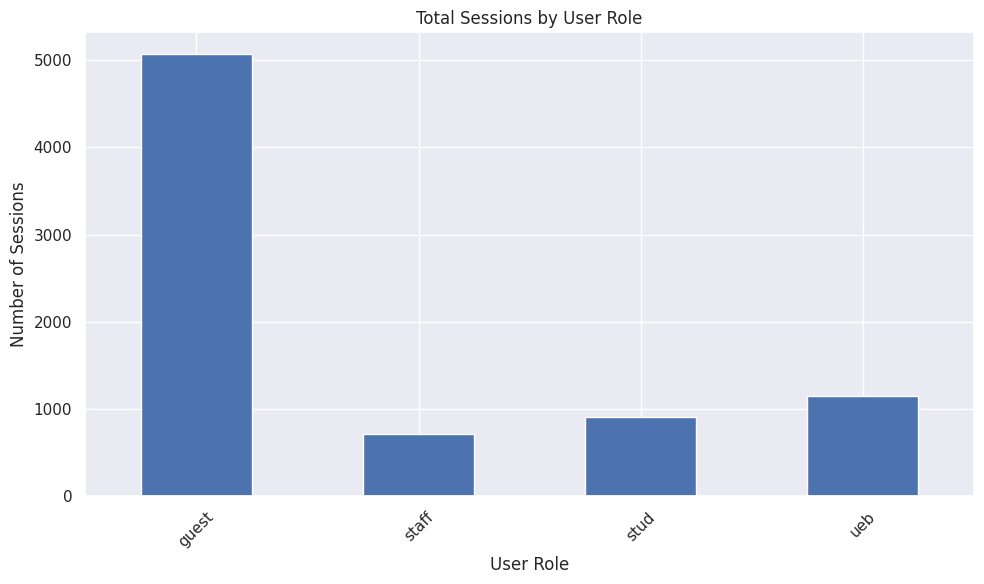

In [18]:
# Plot sessions by role
role_summary['session_count'].plot(kind='bar', figsize=(10, 6))
plt.title('Total Sessions by User Role')
plt.xlabel('User Role')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyze IO Size Distribution

Let's examine the IO operation size distribution.

In [19]:
def get_io_distribution():
    """Get IO size distribution as a pandas DataFrame"""
    conn = get_db_connection()
    
    query = """
    SELECT 
        r.display_text, 
        r.min_bytes,
        r.max_bytes,
        SUM(io.operation_count) as total_operations
    FROM 
        IOOperations io
    JOIN 
        IOSizeRanges r ON io.range_id = r.range_id
    GROUP BY 
        r.range_id
    ORDER BY 
        r.min_bytes
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

io_df = get_io_distribution()
io_df.head()

,display_text,min_bytes,max_bytes,total_operations
0,"[2, 4)",2,4,38223
1,"[4, 8)",4,8,25299
2,"[8, 16)",8,16,93931
3,"[16, 32)",16,32,153160
4,"[32, 64)",32,64,392175


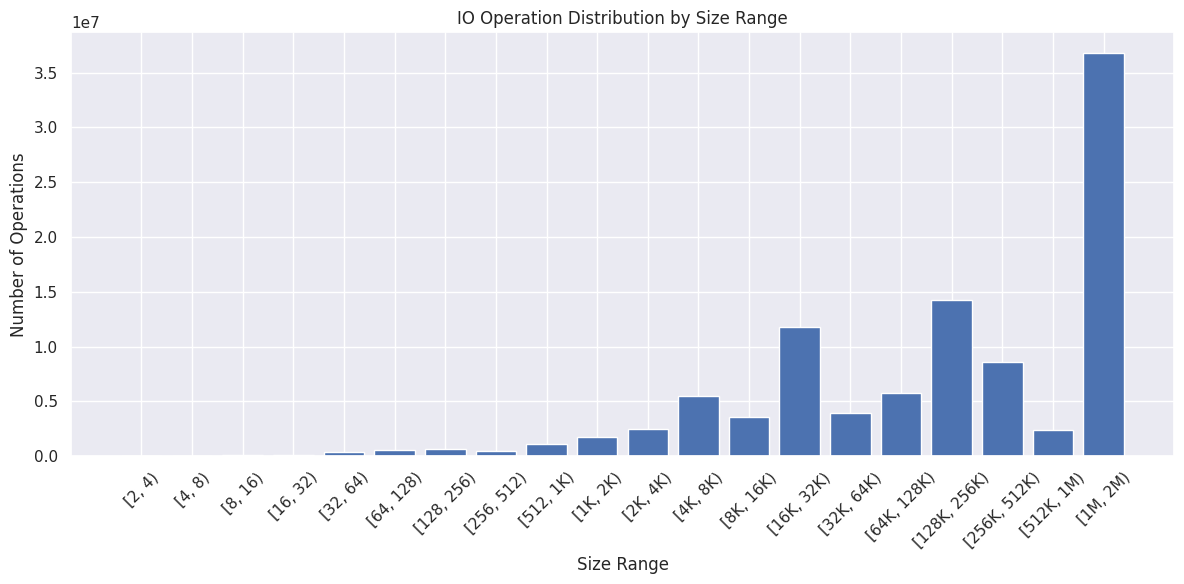

In [20]:
# Plot IO size distribution
plt.figure(figsize=(12, 6))
plt.bar(io_df['display_text'], io_df['total_operations'])
plt.title('IO Operation Distribution by Size Range')
plt.xlabel('Size Range')
plt.ylabel('Number of Operations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyze Time-based Usage Patterns

In [21]:
def get_time_usage():
    """Get time-based usage as a pandas DataFrame"""
    conn = get_db_connection()
    
    query = """
    SELECT 
        l.timestamp, 
        SUM(io.operation_count) as total_operations,
        COUNT(DISTINCT us.user_id) as active_users,
        COUNT(DISTINCT us.machine_id) as active_machines
    FROM 
        IOOperations io
    JOIN 
        UserSessions us ON io.session_id = us.session_id
    JOIN 
        LogEntries l ON us.log_id = l.log_id
    GROUP BY 
        l.timestamp
    ORDER BY 
        l.timestamp
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

time_df = get_time_usage()
time_df.head()

,timestamp,total_operations,active_users,active_machines
0,2025-03-05 01:00:11,47826,8,10
1,2025-03-05 02:00:11,65403,7,6
2,2025-03-05 03:00:11,28657,5,7
3,2025-03-05 04:00:11,36929,5,6
4,2025-03-05 05:00:11,17589,5,4


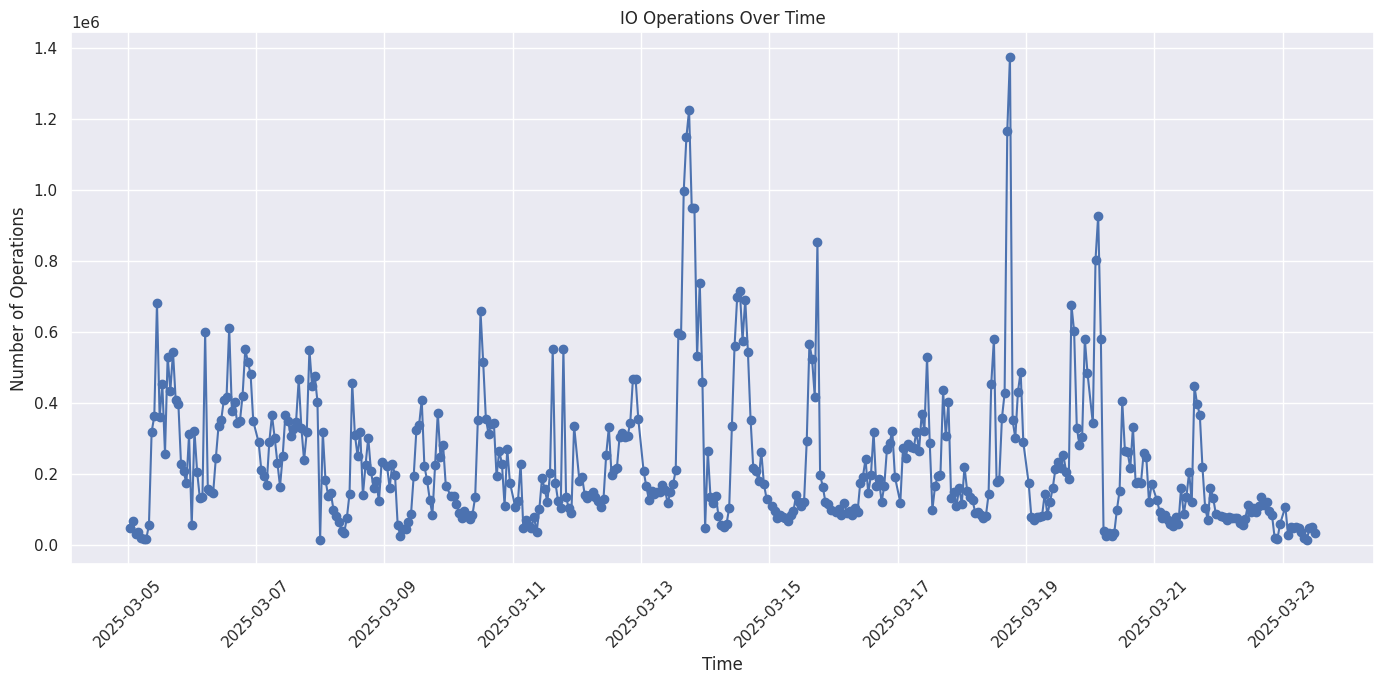

In [22]:
# Plot time series
plt.figure(figsize=(14, 7))
plt.plot(time_df['timestamp'], time_df['total_operations'], marker='o', linestyle='-')
plt.title('IO Operations Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Operations')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Get metrics by user

In [29]:

def get_time_usage_by_user():
    """Get time-based usage as a pandas DataFrame for each user"""
    conn = get_db_connection()
    
    query = """
    SELECT
        l.timestamp,
        u.username,
        SUM(io.operation_count) as total_operations
    FROM
        IOOperations io
    JOIN
        UserSessions us ON io.session_id = us.session_id
    JOIN
        Users u ON us.user_id = u.user_id
    JOIN
        LogEntries l ON us.log_id = l.log_id
    GROUP BY
        l.timestamp, u.username
    ORDER BY
        l.timestamp
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

time_df_by_user = get_time_usage_by_user()
time_df_by_user.head()

,timestamp,username,total_operations
0,2025-03-05 01:00:11,bhoffman,42974
1,2025-03-05 01:00:11,cvonessen,276
2,2025-03-05 01:00:11,dellalia,3596
3,2025-03-05 01:00:11,donchu,364
4,2025-03-05 01:00:11,hodl_001fs25,10


In [31]:
time_df_by_user.groupby('username').get_group('aplesner')

,timestamp,username,total_operations
551,2025-03-06 22:01:11,aplesner,6682
564,2025-03-06 23:01:11,aplesner,1146
697,2025-03-07 14:01:09,aplesner,11349
753,2025-03-07 17:01:09,aplesner,3900
1280,2025-03-10 11:00:13,aplesner,646
1296,2025-03-10 12:00:13,aplesner,5096
1363,2025-03-10 16:00:13,aplesner,4
1553,2025-03-11 09:00:11,aplesner,295
3298,2025-03-16 22:00:12,aplesner,15632
3374,2025-03-17 10:00:06,aplesner,8529


In [33]:
def get_time_stats_for_user(username: str):
    """Get time-based usage statistics for a user with zeros filled in"""
    conn = get_db_connection()

    # Get all timestamps
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT timestamp FROM LogEntries")
    timestamps = [row[0] for row in cursor.fetchall()]

    # Get user data
    query = f"""
    SELECT
        l.timestamp,
        SUM(io.operation_count) as total_operations
    FROM
        IOOperations io
    JOIN
        UserSessions us ON io.session_id = us.session_id
    JOIN
        Users u ON us.user_id = u.user_id
    JOIN
        LogEntries l ON us.log_id = l.log_id
    WHERE
        u.username = '{username}'
    GROUP BY
        l.timestamp
    ORDER BY
        l.timestamp
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Fill in missing timestamps with zeros
    df = df.set_index('timestamp').reindex(timestamps).fillna(0).reset_index()
    df = df.rename(columns={'index': 'timestamp'})
    
    return df

time_df_aplesner = get_time_stats_for_user('aplesner')
time_df_aplesner.head()

,timestamp,total_operations
0,2025-03-05 01:00:11,0.0
1,2025-03-05 02:00:11,0.0
2,2025-03-05 03:00:11,0.0
3,2025-03-05 04:00:11,0.0
4,2025-03-05 05:00:11,0.0


In [32]:
conn = get_db_connection()

# Get all timestamps
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT timestamp FROM LogEntries")
timestamps = [row[0] for row in cursor.fetchall()]

print(f"Found {len(timestamps)} timestamps")
print(timestamps)

conn.close()

Found 430 timestamps
['2025-03-05 01:00:11', '2025-03-05 02:00:11', '2025-03-05 03:00:11', '2025-03-05 04:00:11', '2025-03-05 05:00:11', '2025-03-05 06:00:11', '2025-03-05 07:00:11', '2025-03-05 08:00:11', '2025-03-05 09:00:11', '2025-03-05 10:00:11', '2025-03-05 11:00:11', '2025-03-05 12:00:11', '2025-03-05 13:00:11', '2025-03-05 14:00:11', '2025-03-05 15:00:11', '2025-03-05 16:00:11', '2025-03-05 17:00:11', '2025-03-05 18:00:11', '2025-03-05 19:00:11', '2025-03-05 20:00:11', '2025-03-05 21:00:11', '2025-03-05 22:00:11', '2025-03-05 23:00:11', '2025-03-06 00:00:11', '2025-03-06 01:01:11', '2025-03-06 02:01:11', '2025-03-06 03:01:11', '2025-03-06 04:01:11', '2025-03-06 05:01:11', '2025-03-06 06:01:11', '2025-03-06 07:01:11', '2025-03-06 08:01:11', '2025-03-06 09:01:11', '2025-03-06 10:01:11', '2025-03-06 11:01:11', '2025-03-06 12:01:11', '2025-03-06 13:01:11', '2025-03-06 14:01:11', '2025-03-06 15:01:11', '2025-03-06 16:01:11', '2025-03-06 17:01:11', '2025-03-06 18:01:11', '2025-03-06 

In [ ]:
def get_top_users_recent_logs(log_count=5, user_count=10):
    """Get top users by IO operations for the most recent logs"""
    conn = get_db_connection()
    cursor = conn.cursor()

    query = """
    WITH RecentLogs AS (
        SELECT log_id, timestamp
        FROM LogEntries
        ORDER BY timestamp DESC
        LIMIT ?
    )
    SELECT
        u.username,
        u.user_role,
        u.user_affiliation,
        SUM(io.operation_count) as total_operations,
        COUNT(DISTINCT us.session_id) as session_count,
        COUNT(DISTINCT m.machine_id) as machine_count,
        GROUP_CONCAT(DISTINCT m.machine_name) as machines
    FROM
        IOOperations io
    JOIN
        UserSessions us ON io.session_id = us.session_id
    JOIN
        Users u ON us.user_id = u.user_id
    JOIN
        Machines m ON us.machine_id = m.machine_id
    JOIN
        RecentLogs rl ON us.log_id = rl.log_id
    GROUP BY
        u.user_id
    ORDER BY
        total_operations DESC
    LIMIT ?
    """

    cursor.execute(query, (log_count, user_count))
    users = [dict(row) for row in cursor.fetchall()]

    # Get timestamp range for the recent logs
    cursor.execute("""
    WITH RecentLogs AS (
        SELECT timestamp
        FROM LogEntries
        ORDER BY timestamp DESC
        LIMIT ?
    )
    SELECT MIN(timestamp) as min_date, MAX(timestamp) as max_date
    FROM RecentLogs;
    """, (log_count,))

    date_range = dict(cursor.fetchone())

    conn.close()
    return {
        'users': users,
        'date_range': date_range
    }

In [36]:
d = get_top_users_recent_logs()

In [37]:
d

{'users': [{'username': 'spfisterer',
   'user_role': 'guest',
   'user_affiliation': 'tik',
   'total_operations': 44504,
   'session_count': 3,
   'machine_count': 1,
   'machines': 'tikgpu04'},
  {'username': 'mungersboeck',
   'user_role': 'guest',
   'user_affiliation': 'tik',
   'total_operations': 26285,
   'session_count': 11,
   'machine_count': 3,
   'machines': 'tikgpu08,tikgpu07,tik43x'},
  {'username': 'hodl_001fs25',
   'user_role': 'ueb',
   'user_affiliation': 'tik',
   'total_operations': 23727,
   'session_count': 10,
   'machine_count': 2,
   'machines': 'tik42x,snowflake01'},
  {'username': 'recaky',
   'user_role': 'guest',
   'user_affiliation': 'tik',
   'total_operations': 16110,
   'session_count': 7,
   'machine_count': 3,
   'machines': 'tik42x,tikgpu10,tikgpu04'},
  {'username': 'piroth',
   'user_role': 'guest',
   'user_affiliation': 'tik',
   'total_operations': 12450,
   'session_count': 7,
   'machine_count': 3,
   'machines': 'tik42x,tikgpu04,artongpu0

## Direct SQL Queries

You can also run custom SQL queries directly:

In [23]:
def run_custom_query(query):
    """Run a custom SQL query and return results as a DataFrame"""
    conn = get_db_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Example: Get top 5 users by session count
query = """
SELECT 
    u.username, 
    u.user_role,
    COUNT(DISTINCT us.session_id) as session_count
FROM 
    Users u
JOIN 
    UserSessions us ON u.user_id = us.user_id
GROUP BY 
    u.user_id
ORDER BY 
    session_count DESC
LIMIT 5
"""

top_users = run_custom_query(query)
top_users

,username,user_role,session_count
0,mungersboeck,guest,776
1,hodl_001fs25,ueb,531
2,jlauer,guest,503
3,cvonessen,guest,445
4,jborrell,guest,389


In [ ]:
conn = get_db_connection()
cursor = conn.cursor()

date_range = dict(cursor.fetchone())
conn.close()

print(date_range)

{'min_date': '2025-03-23 08:00:11', 'max_date': '2025-03-23 12:00:11'}
